### Visualize results from anova, include significance

In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.anova_analysis.anova_configs import *
from scripts.anova_analysis.run_anova import load_data
import scipy
import argparse
import copy

In [3]:
def read_good_units(args):
    args.trial_interval = get_trial_interval(args.trial_event)
    output_dir = io_utils.get_anova_output_dir(args)
    good_res = []
    for feat in FEATURES:
        res = pd.read_pickle(os.path.join(output_dir, f"{feat}_.pickle"))
        # TODO: remove when fixed in run_anova
        combined_cond_str = "".join(args.conditions)
        res["combined_fracvar"] = res[f"x_{combined_cond_str}_fracvar"] + res[f"x_TimeBins{combined_cond_str}_fracvar"]
        shuffle_stats = pd.read_pickle(os.path.join(output_dir, f"{feat}_shuffle_stats.pickle"))
        res = pd.merge(res, shuffle_stats, on="PseudoUnitID")
        good_res.append(res[res.combined_fracvar > res["95th"]])
    good_res = pd.concat(good_res)
    unit_pos = pd.read_pickle(UNITS_PATH.format(sub="SA"))
    good_res = pd.merge(good_res, unit_pos[["PseudoUnitID", "structure_level2"]])
    return good_res

### Visualize a few for response/choice interaction

In [14]:
args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args.trial_event = "FeedbackOnsetLong"
# args.conditions = ["FeatPreferred"]
args.conditions = ["Response", "Choice"]
args.time_range = [0, 1500]
# args.beh_filters = {"Response":"Correct","Choice":"Chose","PreferredChosen":True}



In [15]:
good_int_res = read_good_units(args)

### Plots

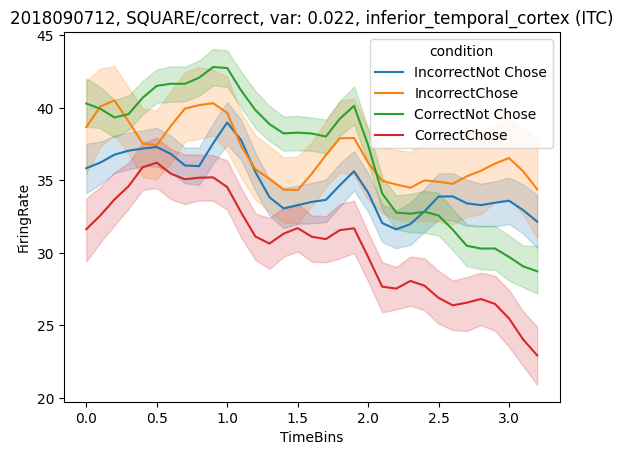

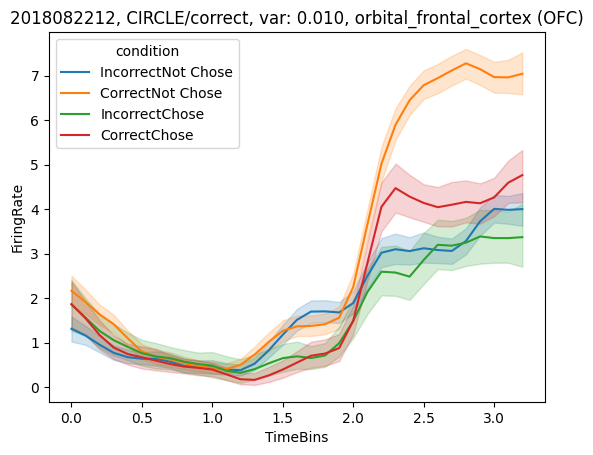

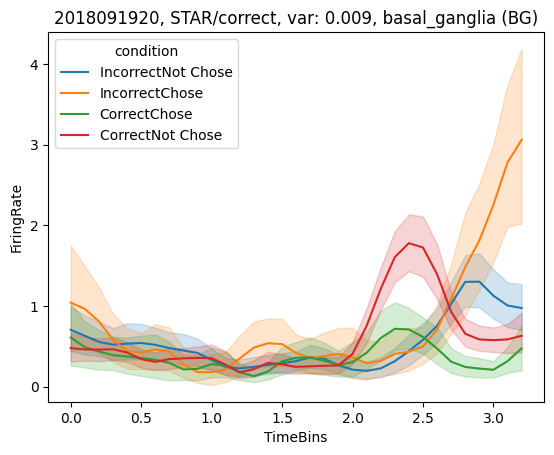

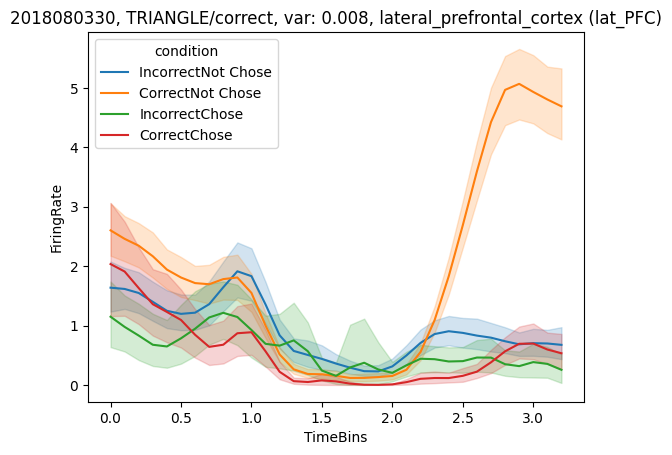

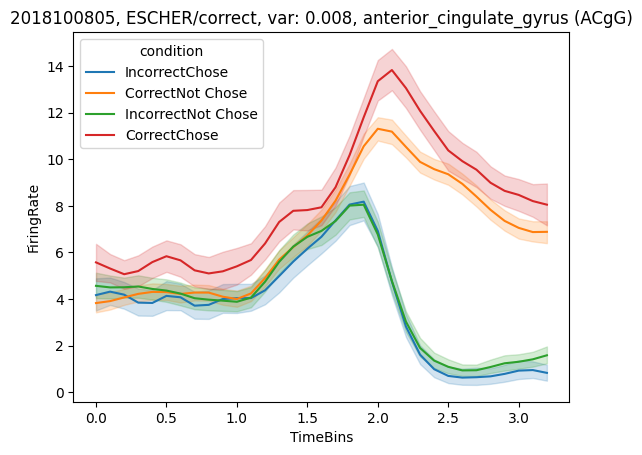

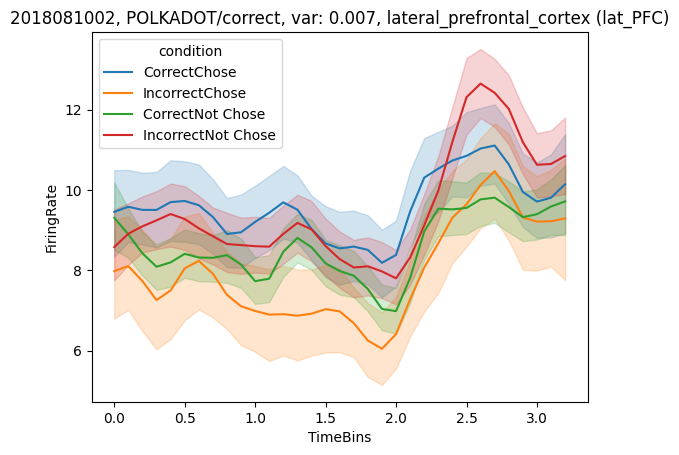

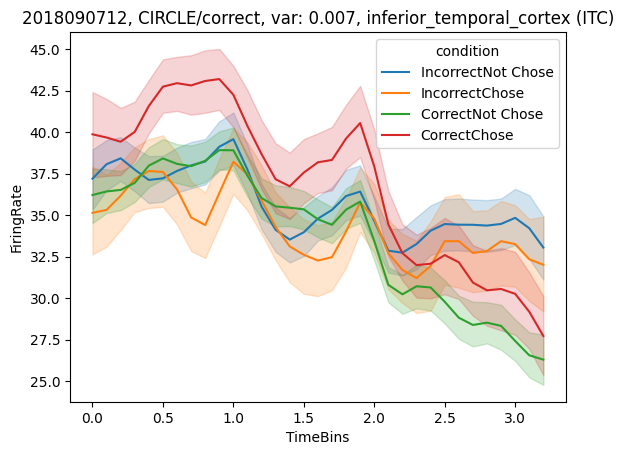

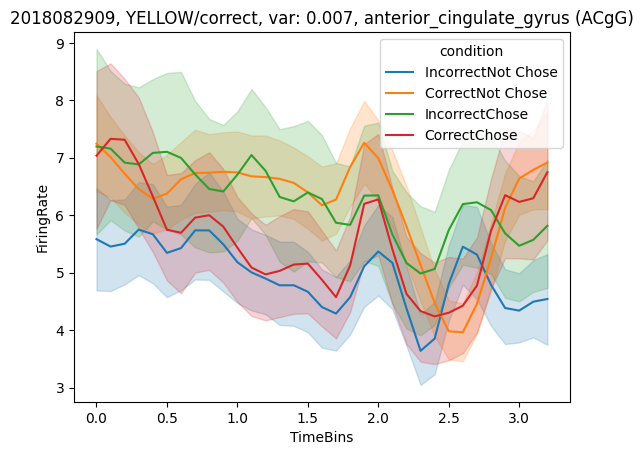

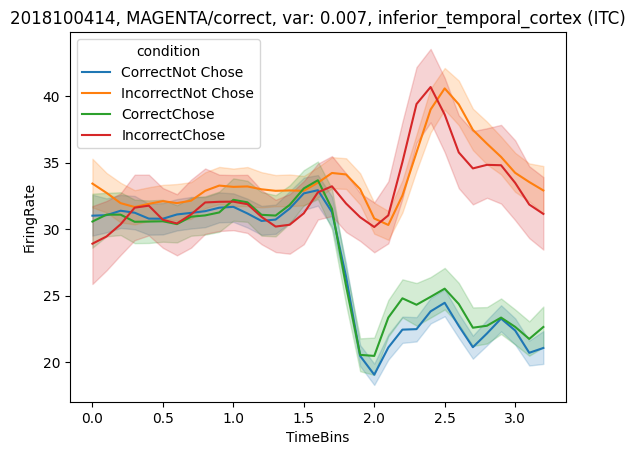

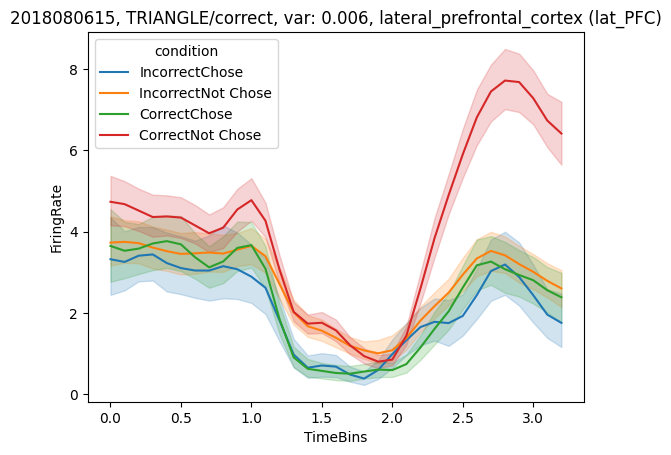

In [8]:
to_vis = good_int_res.sort_values("combined_fracvar", ascending=False)[:10]
for i, unit in to_vis.iterrows():
    unit_id = int(unit.PseudoUnitID)
    args.feat = unit.feat
    data = load_data(int(unit_id / 100), args)
    data = data[data.PseudoUnitID == unit_id]
    data["condition"] = data.apply(lambda x: "".join([x[cond] for cond in args.conditions]), axis=1)
    # unit_frs["FeatPreferred"] = unit_frs["PreferredBelief"].apply(lambda x: x == feat)
    fig, ax = plt.subplots()
    sns.lineplot(data, x="TimeBins", y="FiringRate", hue="condition", ax=ax)
    ax.set_title(f"{unit_id}, {unit.feat}/correct, var: {unit.combined_fracvar:.3f}, {unit.structure_level2}")

### Visualize a few for preferred/not preferred, conditioning on choosing the feature, getting it correct, and the preferred feature being on the chosen card

In [4]:
args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args.trial_event = "FeedbackOnsetLong"
args.conditions = ["FeatPreferred"]
# args.conditions = ["Response", "Choice"]
args.time_range = [0, 1500]
args.beh_filters = {"Response":"Correct","Choice":"Chose","PreferredChosen":True}



In [5]:
good_pref_res = read_good_units(args)

In [6]:
good_pref_res

,PseudoUnitID,total_var,x_TimeBins_fracvar,x_FeatPreferred_fracvar,x_TimeBinsFeatPreferred_fracvar,residual_fracvar,sum_fracvar,feat,combined_fracvar,95th,99th,structure_level2
0,2018070908,6.848873,0.041523,0.020097,0.005298,0.933082,1.0,CIRCLE,0.025395,0.019472,0.024639,lateral_prefrontal_cortex (lat_PFC)
1,2018070908,6.669456,0.052364,0.000759,0.013273,0.933603,1.0,SWIRL,0.014033,0.013330,0.020940,lateral_prefrontal_cortex (lat_PFC)
2,2018070925,27.499069,0.191860,0.009792,0.005747,0.792601,1.0,CIRCLE,0.015539,0.014420,0.016391,motor_cortex (motor)
3,2018070939,79.297038,0.319486,0.013207,0.007642,0.659665,1.0,CIRCLE,0.020849,0.020302,0.022352,motor_cortex (motor)
4,2018091813,16.926999,0.108264,0.011906,0.004022,0.875808,1.0,CIRCLE,0.015928,0.015808,0.018875,medial_pallium (MPal)
...,...,...,...,...,...,...,...,...,...,...,...,...
492,2018061532,22.625270,0.118024,0.010093,0.006743,0.865140,1.0,SWIRL,0.016836,0.015692,0.017821,motor_cortex (motor)
493,2018061533,79.983212,0.117951,0.033661,0.022855,0.825534,1.0,SWIRL,0.056515,0.030289,0.032280,basal_ganglia (BG)
494,2018081720,0.245035,0.015139,0.000794,0.007822,0.976245,1.0,SWIRL,0.008616,0.008377,0.013422,inferior_parietal_lobule (IPL)
495,2018081724,1.273036,0.009522,0.001691,0.009423,0.979364,1.0,SWIRL,0.011114,0.010578,0.012192,anterior_cingulate_gyrus (ACgG)


In [8]:
to_vis = good_pref_res.sort_values("combined_fracvar", ascending=False)[:10]
for i, unit in to_vis.iterrows():
    unit_id = int(unit.PseudoUnitID)
    args.feat = unit.feat
    data = load_data(int(unit_id / 100), args)
    # data = data[data.PseudoUnitID == unit_id]
    # data["condition"] = data.apply(lambda x: "".join([x[cond] for cond in args.conditions]), axis=1)
    # # unit_frs["FeatPreferred"] = unit_frs["PreferredBelief"].apply(lambda x: x == feat)
    # fig, ax = plt.subplots()
    # data["TimeBins"] = data["TimeBins"] - 1.8
    # sns.lineplot(data, x="TimeBins", y="FiringRate", hue="condition", ax=ax)
    # ax.set_title(f"{unit_id}, {unit.feat}/correct, var: {unit.combined_fracvar:.3f}, {unit.structure_level2}")

filter time range
0.0, 15.0
filter time range
0.0, 15.0
filter time range
0.0, 15.0
filter time range
0.0, 15.0
filter time range
0.0, 15.0
filter time range
0.0, 15.0
filter time range
0.0, 15.0
filter time range
0.0, 15.0
filter time range
0.0, 15.0
filter time range
0.0, 15.0
